In [5]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


0.1 0.005018897251342104 arcsec / pix


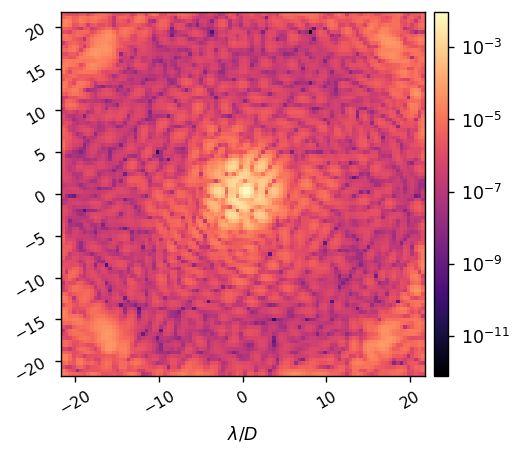

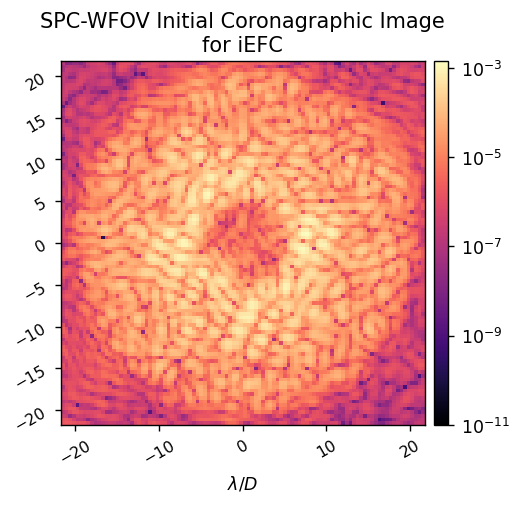

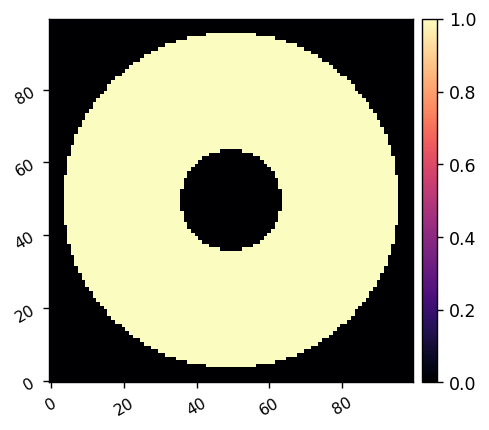

In [42]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide_band1', npsf=100,
                                  use_pupil_defocus=True, 
                                  use_opds=True)
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

roi = utils.create_annular_focal_plane_mask(mode, 6, 20, plot=True)

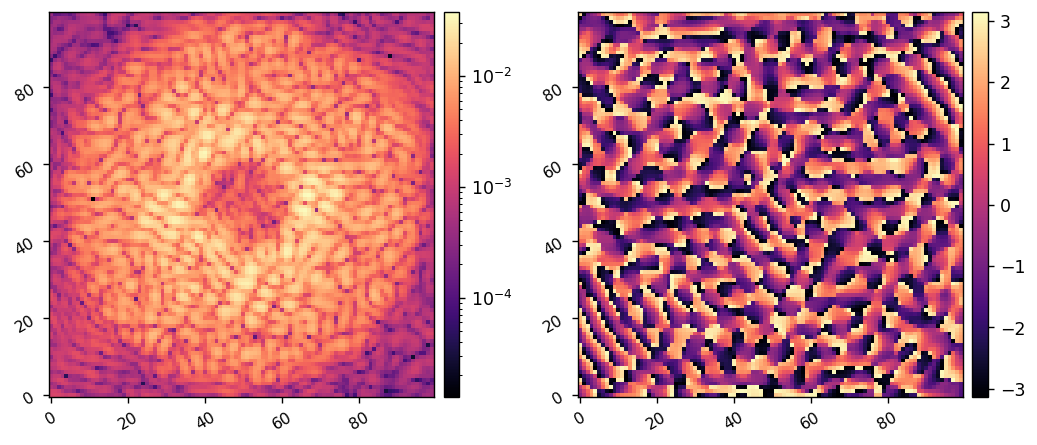

In [29]:
E_im_ref = mode.calc_psf()
imshow2(xp.abs(E_im_ref), xp.angle(E_im_ref), lognorm1=True)

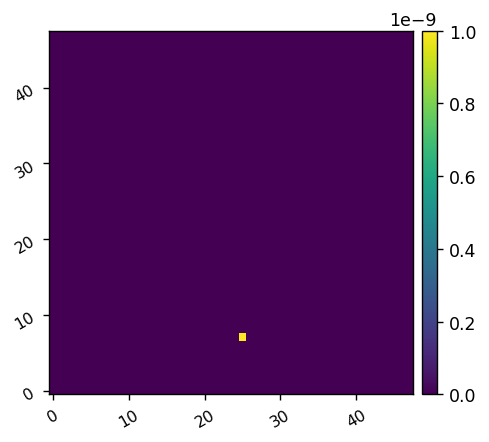

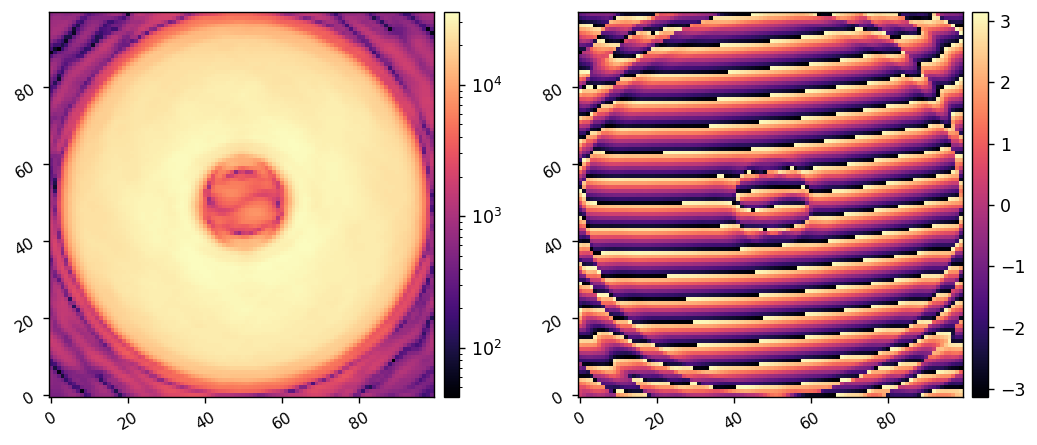

In [48]:
poke_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=1)

poke_amp = 1e-9
poke = poke_amp*poke_modes[180].reshape(mode.Nact,mode.Nact)
imshow1(poke, cmap='viridis')

mode.add_dm1(poke)
E_im_poke_pos = mode.calc_psf()
mode.add_dm1(-poke)

mode.add_dm1(-poke)
E_im_poke_neg = mode.calc_psf()
mode.add_dm1(+poke)

response = (E_im_poke_pos - E_im_poke_neg)/(2*poke_amp)
res_amp = xp.abs(response)
res_phs = xp.angle(response)
imshow2(res_amp, res_phs, lognorm1=True)



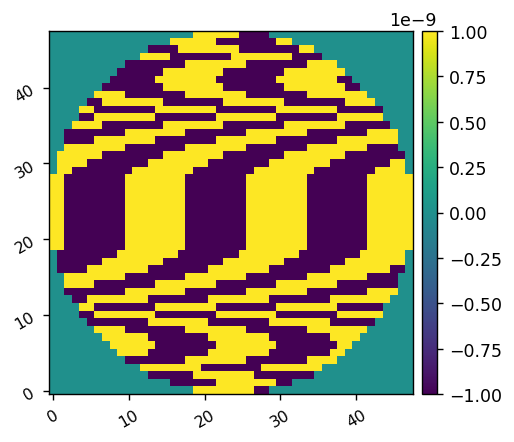

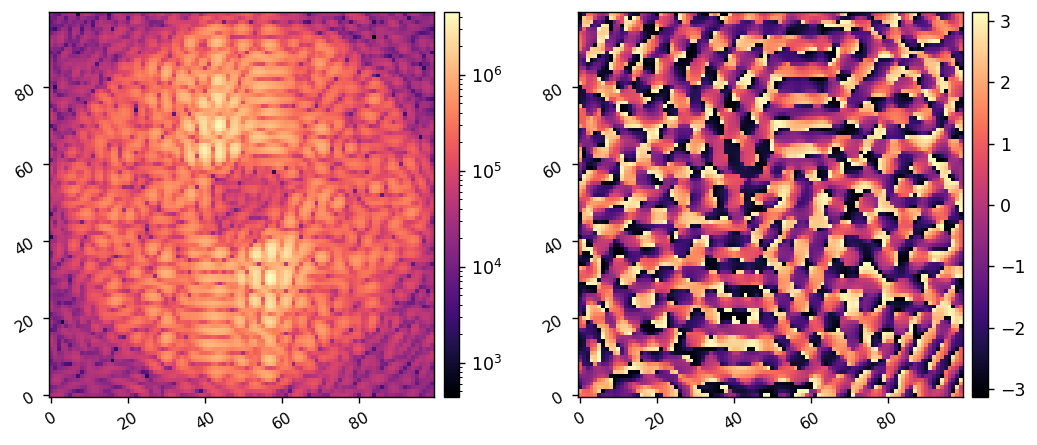

In [49]:
had_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=1)
had_amp = 1e-9
had = had_amp*had_modes[8].reshape(mode.Nact,mode.Nact)
imshow1(had, cmap='viridis')

mode.add_dm1(had)
E_im_had_pos = mode.calc_psf()
mode.add_dm1(-had)

mode.add_dm1(-had)
E_im_had_neg = mode.calc_psf()
mode.add_dm1(+had)

response = (E_im_had_pos - E_im_had_neg)/(2*had_amp)
res_amp = xp.abs(response)
res_phs = xp.angle(response)
imshow2(res_amp, res_phs, lognorm1=True)

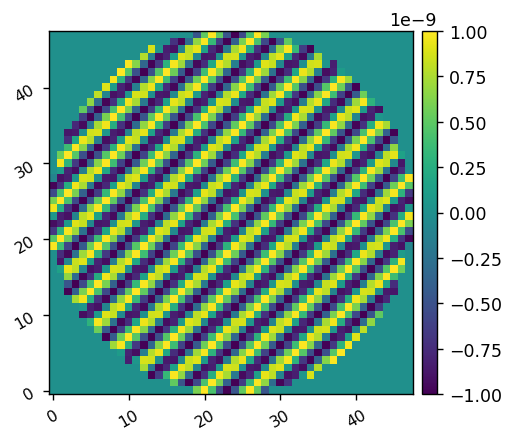

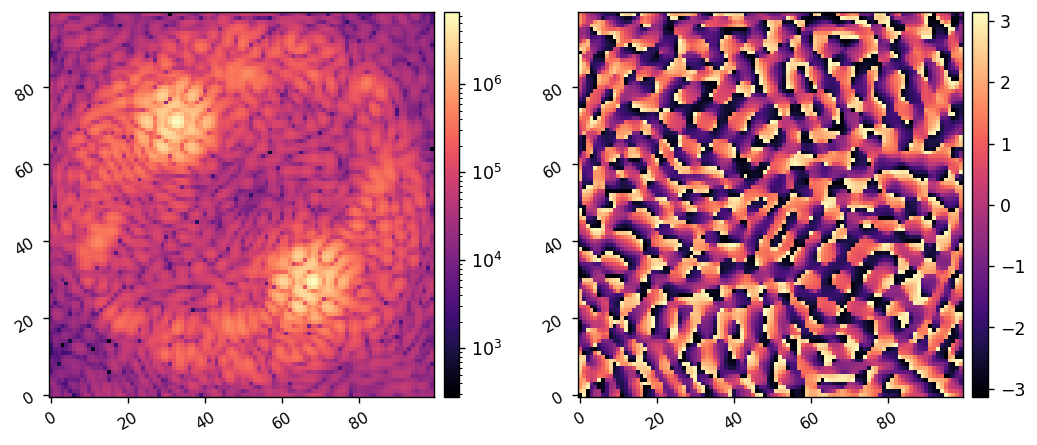

In [56]:
fourier_modes = utils.create_fourier_modes(mode, roi, fourier_sampling=0.75, ndms=1)
fourier_amp = 1e-9
fourier = fourier_amp*fourier_modes[510].reshape(mode.Nact,mode.Nact)
imshow1(fourier, cmap='viridis')

mode.add_dm1(fourier)
E_im_fourier_pos = mode.calc_psf()
mode.add_dm1(-fourier)

mode.add_dm1(-fourier)
E_im_fourier_neg = mode.calc_psf()
mode.add_dm1(+fourier)

response = (E_im_fourier_pos - E_im_fourier_neg)/(2*fourier_amp)
res_amp = xp.abs(response)
res_phs = xp.angle(response)
imshow2(res_amp, res_phs, lognorm1=True)